In [30]:
import pandas as pd
from datetime import datetime
import numpy as np
from tqdm import tqdm
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point
from pyproj import Transformer

In [2]:
s3_sar_5021 = "https://ds-h-ca-bigdata.s3.us-east-2.amazonaws.com/CA_DWR_VERT.csv"
sar_5021 = pd.read_csv(s3_sar_5021)

In [3]:
dry = ["2017", "2019", "2020", "2021"]
wet = ["2015", "2016", "2018", "2022", "2023"] # all in water year beginning Oct --> Sep

In [5]:
sar_5021.head()

,CODE,LAT,LON,HEIGHT,VEL_V,D20150101,D20150107,D20150113,D20150120,D20150126,...,D20240813,D20240820,D20240826,D20240901,D20240907,D20240913,D20240919,D20240925,D20241001,Basin_Subb
0,DX5IPRM,40.338973,-122.018572,320.85570,-1.6,NaN,NaN,NaN,NaN,NaN,...,-0.6,1.2,3.1,3.7,3.6,4.9,6.3,5.2,3.4,5-021.53
1,DX5IPRN,40.338973,-122.017438,673.82640,-0.6,NaN,NaN,NaN,NaN,NaN,...,-1.8,-1.5,-1.3,-1.2,-1.0,-0.3,-0.2,-0.2,-0.4,5-021.53
2,DX5IPRO,40.338973,-122.016305,10.95188,-0.3,NaN,NaN,NaN,NaN,NaN,...,1.2,1.2,1.5,2.0,2.1,2.5,2.5,2.6,2.0,5-021.53
3,DX5IPRP,40.338973,-122.015171,140.33210,-1.1,NaN,NaN,NaN,NaN,NaN,...,-0.0,0.3,1.0,1.8,2.1,2.8,3.0,2.9,2.1,5-021.53
4,DX5IPRQ,40.338973,-122.014037,25.95095,-0.1,NaN,NaN,NaN,NaN,NaN,...,3.3,3.7,4.5,5.3,5.3,5.6,5.6,5.4,4.5,5-021.53


In [9]:
def is_oct_2015_or_later(col_name):
    if col_name.startswith('D') and len(col_name) == 9:
        try:
            date_str = col_name[1:]
            date = datetime.strptime(date_str, '%Y%m%d')
            return date >= datetime(2015, 10, 1)
        except ValueError:
            return False
    return True

In [10]:
wy_2015_or_later = [col for col in sar_5021.columns if is_oct_2015_or_later(col)]

In [12]:
sar_5021_2015 = sar_5021[wy_2015_or_later].copy()

In [36]:
def extract_year_month(col_name):
    if col_name.startswith('D') and len(col_name) == 9:
        try:
            date_str = col_name[1:]
            date = datetime.strptime(date_str, '%Y%m%d')
            return date.year, date.month
        except ValueError:
            pass
    return None, None

year_month_columns = {}
for col in sar_5021_2015.columns:
    year, month = extract_year_month(col)
    if year is not None:
        year_month_columns.setdefault((year, month), []).append(col)

def calculate_average(row, columns):
    valid_values = [row[col] for col in columns if not pd.isna(row[col])]
    return np.mean(valid_values) if valid_values else np.nan

results = []
for index, row in tqdm(sar_5021_2015.iterrows(), total=len(sar_5021_2015), desc="Processing rows"):
    row_results = {'CODE': row['CODE']}
    for (year, month), columns in year_month_columns.items():
        if month == 10:
            oct_avg = calculate_average(row, columns)
            next_year_sep_columns = year_month_columns.get((year + 1, 9), [])
            sep_avg = calculate_average(row, next_year_sep_columns)
            if not np.isnan(oct_avg) and not np.isnan(sep_avg):
                row_results[f'Diff_{year}'] = oct_avg - sep_avg
    results.append(row_results)

wy_sar_5021 = pd.DataFrame(results)

Processing rows: 100%|██████████| 707344/707344 [07:02<00:00, 1675.38it/s]


In [37]:
def extract_year(col_name):
    if col_name.startswith('D') and len(col_name) == 9:
        return col_name.split("_")[1]
    return None

dry_columns = [col for col in wy_sar_5021.columns if extract_year(col) in dry]
wet_columns = [col for col in wy_sar_5021.columns if extract_year(col) in wet]

print("Dry Year Columns:", dry_columns)
print("Wet Year Columns:", wet_columns)

results = []
for idx, row in tqdm(wy_sar_5021.iterrows(), total=len(wy_sar_5021), desc="Processing wells"):
    well_code = row['CODE']
    dry_avg = row[dry_columns].mean()
    wet_avg = row[wet_columns].mean()
    results.append({
        'CODE': well_code,
        'Dry_Year_Avg': dry_avg,
        'Wet_Year_Avg': wet_avg
    })

wy_sar_5021_dry_wet = pd.DataFrame(results)

Dry Year Columns: ['Diff_2017', 'Diff_2020', 'Diff_2021', 'Diff_2019']
Wet Year Columns: ['Diff_2015', 'Diff_2016', 'Diff_2018', 'Diff_2022', 'Diff_2023']


Processing wells: 100%|██████████| 707344/707344 [08:02<00:00, 1464.48it/s]


In [31]:
SGMA = "../data/GWBasins.shp"
gdf = gpd.read_file(SGMA)
gdf.set_crs(epsg=3857, inplace=True)
gdf.set_index('OBJECTID', inplace=True)
gdf['Basin_Prefix'] = gdf['Basin_Numb'].str.split('-').str[0].astype(int)

In [39]:
wy_sar_5021_dry_wet.head()

,CODE,Dry_Year_Avg,Wet_Year_Avg
0,DX5IPRM,0.283333,2.226
1,DX5IPRN,-1.985000,3.196
2,DX5IPRO,-2.105000,2.860
3,DX5IPRP,-1.195000,3.244
4,DX5IPRQ,-2.605000,3.740


In [42]:
wy_sar_5021_dry_wet = pd.merge(wy_sar_5021_dry_wet, sar_5021[["CODE", "LAT", "LON"]], on="CODE", how='left')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


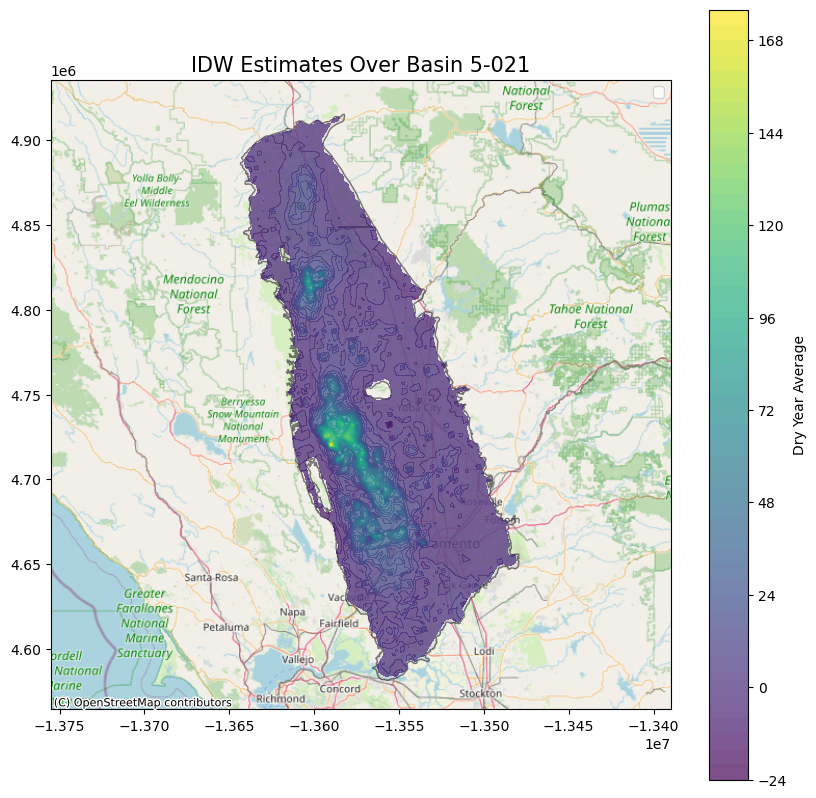

In [44]:
filtered_gdf = gdf[gdf['Basin_Numb'] == '5-021']

larger_polygon = filtered_gdf.dissolve().geometry.iloc[0]
larger_polygon_gdf = gpd.GeoDataFrame(geometry=[larger_polygon], crs=filtered_gdf.crs)
larger_polygon_gdf = larger_polygon_gdf.to_crs(epsg=32633)
bounds = larger_polygon_gdf.total_bounds

wells_gdf = gpd.GeoDataFrame(
    wy_sar_5021_dry_wet,
    geometry=gpd.points_from_xy(wy_sar_5021_dry_wet['LON'], wy_sar_5021_dry_wet['LAT']),
    crs="EPSG:4326"
)
wells_gdf = wells_gdf.to_crs(larger_polygon_gdf.crs)

x = wells_gdf.geometry.x.values
y = wells_gdf.geometry.y.values
z = wells_gdf['Dry_Year_Avg'].values

grid_x = np.linspace(bounds[0], bounds[2], num=100)
grid_y = np.linspace(bounds[1], bounds[3], num=100)
xx, yy = np.meshgrid(grid_x, grid_y)

def idw_interpolation(x, y, z, grid_x, grid_y, power=2):
    grid_z = np.empty((len(grid_y), len(grid_x)))
    k = 100
    for i, xi in enumerate(grid_x):
        for j, yi in enumerate(grid_y):
            d = np.sqrt((x - xi)**2 + (y - yi)**2)
            valid = ~np.isnan(z)
            if not np.any(valid):
                grid_z[j, i] = np.nan
                continue

            d_valid = d[valid]
            z_valid = z[valid]

            k_actual = min(k, len(d_valid))
            idx_sorted = np.argsort(d_valid)[:k_actual]
            d_nearest = d_valid[idx_sorted]
            z_nearest = z_valid[idx_sorted]

            if np.any(d_nearest == 0):
                grid_z[j, i] = z_nearest[d_nearest == 0][0]
            else:
                weights = 1 / d_nearest**power
                grid_z[j, i] = np.sum(weights * z_nearest) / np.sum(weights)
    return grid_z

z_interp = idw_interpolation(x, y, z, grid_x, grid_y, power=2)

grid_points = np.vstack((xx.flatten(), yy.flatten())).T
grid_points_gdf = gpd.GeoSeries(
    gpd.points_from_xy(grid_points[:, 0], grid_points[:, 1]),
    crs=larger_polygon_gdf.crs
)

mask = grid_points_gdf.within(larger_polygon_gdf.geometry.iloc[0])
mask = mask.values.reshape(xx.shape)
z_interp_masked = np.ma.masked_where(~mask, z_interp)

larger_polygon_3857 = larger_polygon_gdf.to_crs(epsg=3857)
wells_gdf_3857 = wells_gdf.to_crs(epsg=3857)

transformer = Transformer.from_crs("EPSG:32633", "EPSG:3857", always_xy=True)
xx_3857, yy_3857 = transformer.transform(xx, yy)

fig, ax = plt.subplots(figsize=(10, 10))
larger_polygon_3857.plot(
    ax=ax, 
    color='lightgray', 
    edgecolor='black', 
    alpha=0.5
)

contour = ax.contourf(
    xx_3857, 
    yy_3857, 
    z_interp_masked, 
    levels=50, 
    cmap='viridis', 
    alpha=0.7
)

cbar = plt.colorbar(contour, ax=ax)
cbar.set_label('Dry Year Average')

ax.set_title('IDW Estimates Over Basin 5-021', fontsize=15)
ax.legend()
ax.set_aspect('equal')

ctx.add_basemap(
    ax, 
    crs=larger_polygon_3857.crs,
    source=ctx.providers.OpenStreetMap.Mapnik
)

plt.show()